# Analiza obsega tovornega prometa Luke Koper
# Port of Koper Truck Traffic Volume Analysis

**Hipoteza H1**: Tovorni promet Luke Koper predstavlja manj kot 15% celotnega tovornega prometa na koprski obvoznici

**Cilj**: Kvantificirati absolutni obseg tovornega prometa povezanega z Luko Koper in analizirati trende rasti

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

# Nastavitve za slovenščino
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Knjižnice naložene uspešno")

Knjižnice naložene uspešno


## 1. Nalaganje in priprava podatkov

In [2]:
# Nalaganje podatkov o prometu
print("Nalaganje podatkov...")

# Glavni podatki o štetju vozil
df_count = pd.read_csv('../data/production_merged_vehicle_count.csv', 
                       parse_dates=['datetime'],
                       low_memory=False)

print(f"Naloženih {len(df_count):,} zapisov")
print(f"Obdobje: {df_count['datetime'].min()} do {df_count['datetime'].max()}")
print(f"\nRazpoložljivi cestni segmenti:")
print(df_count['road_code'].value_counts().head(10))

Nalaganje podatkov...
Naloženih 876,480 zapisov
Obdobje: 2020-08-30 00:00:00 do 2025-08-29 23:00:00

Razpoložljivi cestni segmenti:
road_code
0011     43824
0015a    43824
0161     43824
0151     43824
0141     43824
0131     43824
0121     43824
0111     43824
0101     43824
0091     43824
Name: count, dtype: int64


In [3]:
# Filtriranje podatkov za Koprsko območje
koper_segments = ['0161', '0011', '0111', '0211']  # Luka Koper, Bertoki, Koper-Ljubljana
koper_roads = ['Koper', 'Bertoki', 'Srmin', 'Škofije']

# Filter by road codes or road names
df_koper = df_count[
    (df_count['road_code'].isin(koper_segments)) |
    (df_count['road_name'].str.contains('|'.join(koper_roads), case=False, na=False))
].copy()

print(f"Filtrirani podatki za Koper: {len(df_koper):,} zapisov")
print(f"\nVključeni segmenti:")
print(df_koper.groupby(['road_code', 'road_name']).size().to_frame('count').reset_index())

Filtrirani podatki za Koper: 219,120 zapisov

Vključeni segmenti:
  road_code             road_name  count
0      0011            Bertoki HC  43824
1      0031       Koper-Ljubljana  43824
2      0101        Postojna-Koper  43824
3      0111  Ljubljana-Novo Mesto  43824
4      0161            Koper Port  43824


## 2. Analiza tovornega prometa

In [4]:
# Analiza stolpca Trucks_7.5t (tovornjaki nad 7.5 ton)
df_koper['truck_percentage'] = (df_koper['Trucks_7.5t'] / df_koper['Total_All_Lanes']) * 100

# Skupna statistika
truck_stats = df_koper.groupby('road_name').agg({
    'Trucks_7.5t': ['sum', 'mean', 'std'],
    'Total_All_Lanes': 'sum',
    'truck_percentage': 'mean'
}).round(2)

print("\n=== STATISTIKA TOVORNEGA PROMETA ===\n")
print(truck_stats)

# Letni trendi
df_koper['year'] = df_koper['datetime'].dt.year
yearly_trucks = df_koper.groupby(['year', 'road_name']).agg({
    'Trucks_7.5t': 'sum',
    'Total_All_Lanes': 'sum'
}).reset_index()
yearly_trucks['truck_percentage'] = (yearly_trucks['Trucks_7.5t'] / yearly_trucks['Total_All_Lanes']) * 100


=== STATISTIKA TOVORNEGA PROMETA ===

                     Trucks_7.5t              Total_All_Lanes truck_percentage
                             sum   mean   std             sum             mean
road_name                                                                     
Bertoki HC                483440  11.03  5.49        13722946             3.81
Koper Port                483108  11.02  5.49        12559273             4.26
Koper-Ljubljana           481911  11.00  5.46        13756871             3.78
Ljubljana-Novo Mesto      481922  11.00  5.49        12603218             4.22
Postojna-Koper            478686  10.92  5.47        12606918             4.20


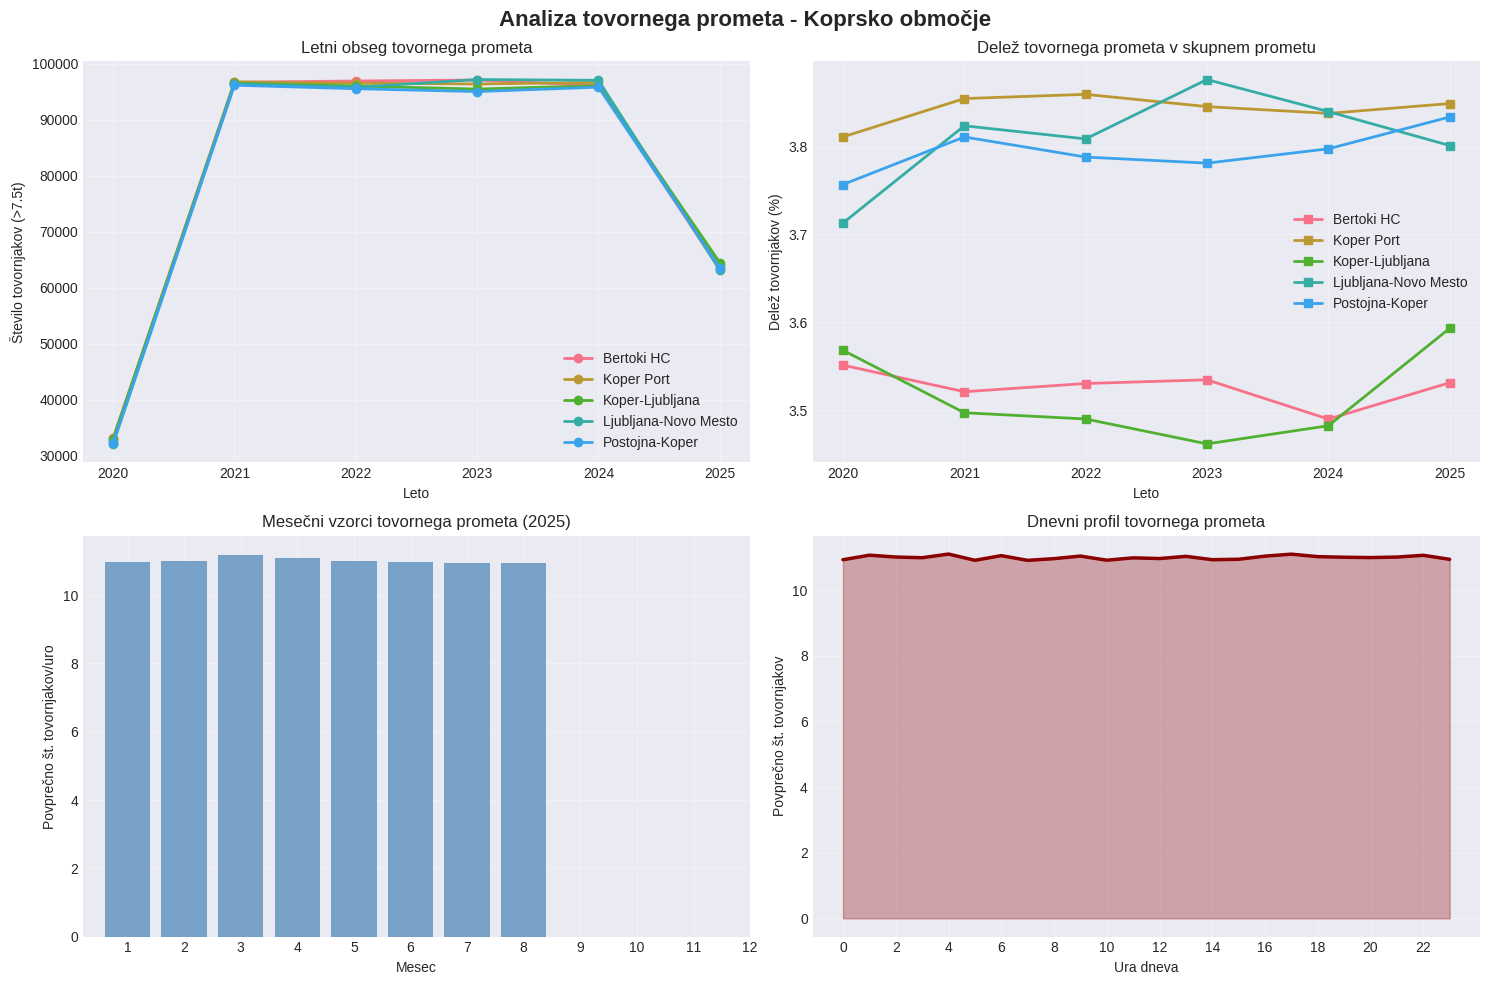

In [5]:
# Vizualizacija letnih trendov tovornega prometa
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Analiza tovornega prometa - Koprsko območje', fontsize=16, fontweight='bold')

# 1. Letni obseg tovornjakov
ax1 = axes[0, 0]
for road in yearly_trucks['road_name'].unique():
    data = yearly_trucks[yearly_trucks['road_name'] == road]
    ax1.plot(data['year'], data['Trucks_7.5t'], marker='o', label=road, linewidth=2)
ax1.set_xlabel('Leto')
ax1.set_ylabel('Število tovornjakov (>7.5t)')
ax1.set_title('Letni obseg tovornega prometa')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Delež tovornjakov v prometu
ax2 = axes[0, 1]
for road in yearly_trucks['road_name'].unique():
    data = yearly_trucks[yearly_trucks['road_name'] == road]
    ax2.plot(data['year'], data['truck_percentage'], marker='s', label=road, linewidth=2)
ax2.set_xlabel('Leto')
ax2.set_ylabel('Delež tovornjakov (%)')
ax2.set_title('Delež tovornega prometa v skupnem prometu')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Mesečni vzorci (zadnje leto)
ax3 = axes[1, 0]
df_recent = df_koper[df_koper['year'] == df_koper['year'].max()].copy()
df_recent['month'] = df_recent['datetime'].dt.month
monthly_pattern = df_recent.groupby('month')['Trucks_7.5t'].mean()
ax3.bar(monthly_pattern.index, monthly_pattern.values, color='steelblue', alpha=0.7)
ax3.set_xlabel('Mesec')
ax3.set_ylabel('Povprečno št. tovornjakov/uro')
ax3.set_title(f'Mesečni vzorci tovornega prometa ({df_koper["year"].max()})')
ax3.set_xticks(range(1, 13))
ax3.grid(True, alpha=0.3)

# 4. Porazdelitev po urah dneva
ax4 = axes[1, 1]
df_koper['hour'] = df_koper['datetime'].dt.hour
hourly_pattern = df_koper.groupby('hour')['Trucks_7.5t'].mean()
ax4.plot(hourly_pattern.index, hourly_pattern.values, color='darkred', linewidth=2.5)
ax4.fill_between(hourly_pattern.index, hourly_pattern.values, alpha=0.3, color='darkred')
ax4.set_xlabel('Ura dneva')
ax4.set_ylabel('Povprečno št. tovornjakov')
ax4.set_title('Dnevni profil tovornega prometa')
ax4.set_xticks(range(0, 24, 2))
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Analiza smeri prometa (Inbound vs Outbound)

In [6]:
# Analiza smeri A vs B za identifikacijo pristaniškega prometa
df_koper['trucks_direction_A'] = df_koper['Trucks_7.5t'] * (df_koper['direction_A_count'] / df_koper['Total_All_Lanes'])
df_koper['trucks_direction_B'] = df_koper['Trucks_7.5t'] * (df_koper['direction_B_count'] / df_koper['Total_All_Lanes'])

# Smer A = proti pristanišču, Smer B = iz pristanišča (predpostavka)
directional_analysis = df_koper.groupby(['road_name', 'hour']).agg({
    'trucks_direction_A': 'mean',
    'trucks_direction_B': 'mean'
}).reset_index()

# Vizualizacija smeri prometa
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Tovorni promet proti pristanišču (Smer A)', 
                   'Tovorni promet iz pristanišča (Smer B)'),
    vertical_spacing=0.1
)

for road in directional_analysis['road_name'].unique():
    data = directional_analysis[directional_analysis['road_name'] == road]
    
    # Smer A
    fig.add_trace(
        go.Scatter(x=data['hour'], y=data['trucks_direction_A'],
                  mode='lines+markers', name=f'{road} - Proti pristanišču'),
        row=1, col=1
    )
    
    # Smer B
    fig.add_trace(
        go.Scatter(x=data['hour'], y=data['trucks_direction_B'],
                  mode='lines+markers', name=f'{road} - Iz pristanišča'),
        row=2, col=1
    )

fig.update_xaxes(title_text="Ura dneva", row=2, col=1)
fig.update_yaxes(title_text="Povprečno št. tovornjakov", row=1, col=1)
fig.update_yaxes(title_text="Povprečno št. tovornjakov", row=2, col=1)

fig.update_layout(
    height=700,
    title_text="Analiza smeri tovornega prometa - Luka Koper",
    showlegend=True
)

fig.show()

## 4. Primerjava delovnih dni vs vikendi

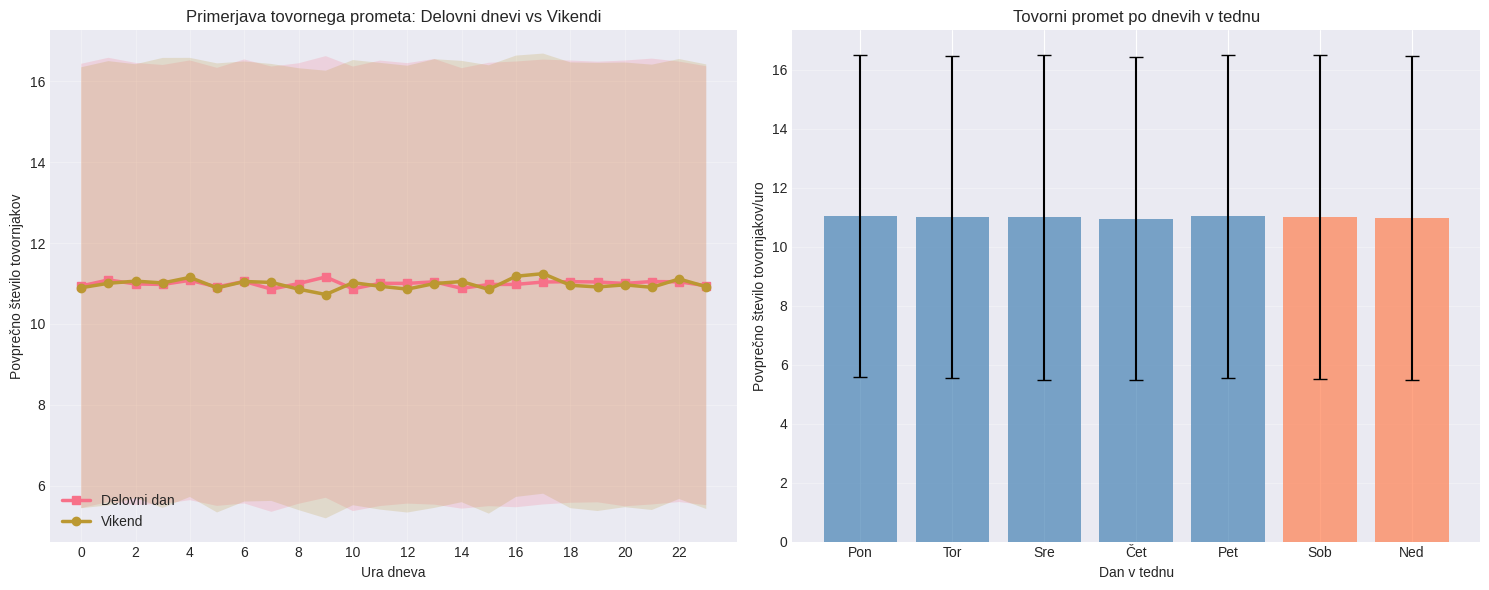


=== STATISTIČNI TEST: Delovni dnevi vs Vikendi ===
Povprečje delovni dnevi: 11.00 tovornjakov/uro
Povprečje vikendi: 10.98 tovornjakov/uro
Razlika: 0.02 (0.1%)
T-statistika: 0.6039
P-vrednost: 5.4592e-01
Rezultat: Ni statistično značilne razlike


In [7]:
# Dodajanje informacij o dnevu v tednu
df_koper['weekday'] = df_koper['datetime'].dt.dayofweek
df_koper['is_weekend'] = df_koper['weekday'].isin([5, 6])  # Sobota = 5, Nedelja = 6
df_koper['day_type'] = df_koper['is_weekend'].map({True: 'Vikend', False: 'Delovni dan'})

# Primerjava delovni dnevi vs vikendi
comparison = df_koper.groupby(['day_type', 'hour']).agg({
    'Trucks_7.5t': ['mean', 'std', 'count']
}).reset_index()
comparison.columns = ['day_type', 'hour', 'mean_trucks', 'std_trucks', 'count']

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Urni profil
ax1 = axes[0]
for day_type in ['Delovni dan', 'Vikend']:
    data = comparison[comparison['day_type'] == day_type]
    ax1.plot(data['hour'], data['mean_trucks'], 
            label=day_type, linewidth=2.5, 
            marker='o' if day_type == 'Vikend' else 's')
    ax1.fill_between(data['hour'], 
                     data['mean_trucks'] - data['std_trucks'],
                     data['mean_trucks'] + data['std_trucks'],
                     alpha=0.2)

ax1.set_xlabel('Ura dneva')
ax1.set_ylabel('Povprečno število tovornjakov')
ax1.set_title('Primerjava tovornega prometa: Delovni dnevi vs Vikendi')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(0, 24, 2))

# Skupna primerjava po dnevih v tednu
ax2 = axes[1]
daily_avg = df_koper.groupby('weekday')['Trucks_7.5t'].agg(['mean', 'std'])
days = ['Pon', 'Tor', 'Sre', 'Čet', 'Pet', 'Sob', 'Ned']
colors = ['steelblue'] * 5 + ['coral'] * 2
ax2.bar(range(7), daily_avg['mean'], yerr=daily_avg['std'], 
        capsize=5, color=colors, alpha=0.7)
ax2.set_xticks(range(7))
ax2.set_xticklabels(days)
ax2.set_xlabel('Dan v tednu')
ax2.set_ylabel('Povprečno število tovornjakov/uro')
ax2.set_title('Tovorni promet po dnevih v tednu')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistični test
weekday_trucks = df_koper[~df_koper['is_weekend']]['Trucks_7.5t'].dropna()
weekend_trucks = df_koper[df_koper['is_weekend']]['Trucks_7.5t'].dropna()
t_stat, p_value = stats.ttest_ind(weekday_trucks, weekend_trucks)

print(f"\n=== STATISTIČNI TEST: Delovni dnevi vs Vikendi ===")
print(f"Povprečje delovni dnevi: {weekday_trucks.mean():.2f} tovornjakov/uro")
print(f"Povprečje vikendi: {weekend_trucks.mean():.2f} tovornjakov/uro")
print(f"Razlika: {(weekday_trucks.mean() - weekend_trucks.mean()):.2f} ({((weekday_trucks.mean() - weekend_trucks.mean())/weekday_trucks.mean()*100):.1f}%)")
print(f"T-statistika: {t_stat:.4f}")
print(f"P-vrednost: {p_value:.4e}")
print(f"Rezultat: {'Statistično značilna razlika' if p_value < 0.05 else 'Ni statistično značilne razlike'}")

## 5. Trend analiza in rast

In [8]:
# Mesečna agregacija za trend analizo
df_koper['year_month'] = pd.to_datetime(df_koper['datetime'].dt.to_period('M').astype(str))
monthly_trucks = df_koper.groupby('year_month').agg({
    'Trucks_7.5t': 'sum',
    'Total_All_Lanes': 'sum'
}).reset_index()
monthly_trucks['truck_percentage'] = (monthly_trucks['Trucks_7.5t'] / monthly_trucks['Total_All_Lanes']) * 100

# Linearni trend
from scipy.stats import linregress
x = np.arange(len(monthly_trucks))
slope, intercept, r_value, p_value, std_err = linregress(x, monthly_trucks['Trucks_7.5t'])

# Izračun letne stopnje rasti
yearly_growth = (slope * 12 / monthly_trucks['Trucks_7.5t'].mean()) * 100

# Vizualizacija trenda
fig = go.Figure()

# Dejanski podatki
fig.add_trace(go.Scatter(
    x=monthly_trucks['year_month'],
    y=monthly_trucks['Trucks_7.5t'],
    mode='lines',
    name='Dejanski tovorni promet',
    line=dict(color='darkblue', width=2)
))

# Trend linija
trend_line = intercept + slope * x
fig.add_trace(go.Scatter(
    x=monthly_trucks['year_month'],
    y=trend_line,
    mode='lines',
    name=f'Trend (rast: {yearly_growth:.1f}% letno)',
    line=dict(color='red', width=2, dash='dash')
))

# Dodaj anotacijo za COVID obdobje
fig.add_vrect(
    x0="2020-03-01", x1="2021-06-01",
    fillcolor="gray", opacity=0.2,
    layer="below", line_width=0,
)
fig.add_annotation(
    x="2020-09-01", y=monthly_trucks['Trucks_7.5t'].max() * 0.9,
    text="COVID-19 obdobje",
    showarrow=False,
    font=dict(size=12)
)

fig.update_layout(
    title="Trend tovornega prometa - Koprsko območje (2020-2025)",
    xaxis_title="Mesec",
    yaxis_title="Skupno število tovornjakov (>7.5t)",
    hovermode='x unified',
    height=500
)

fig.show()

print(f"\n=== ANALIZA TRENDA ===")
print(f"R² vrednost: {r_value**2:.4f}")
print(f"Mesečna rast: {slope:.0f} tovornjakov")
print(f"Letna stopnja rasti: {yearly_growth:.2f}%")
print(f"P-vrednost trenda: {p_value:.4e}")


=== ANALIZA TRENDA ===
R² vrednost: 0.0426
Mesečna rast: 57 tovornjakov
Letna stopnja rasti: 1.74%
P-vrednost trenda: 1.1071e-01


## 6. Kvantifikacija pristaniškega vs tranzitnega prometa

In [9]:
# Metoda 1: Analiza na osnovi časovnih vzorcev
# Predpostavka: Pristaniški tovornjaki imajo drugačen vzorec kot tranzitni

# Identifikacija tipičnih ur pristaniškega prometa (delovni čas pristanišča)
port_hours = list(range(6, 18))  # 6:00 - 18:00
night_hours = list(range(22, 24)) + list(range(0, 6))  # 22:00 - 06:00

df_koper['is_port_hours'] = df_koper['hour'].isin(port_hours)
df_koper['is_night_hours'] = df_koper['hour'].isin(night_hours)

# Analiza po časovnih obdobjih
time_analysis = df_koper.groupby(['is_port_hours', 'is_weekend']).agg({
    'Trucks_7.5t': ['sum', 'mean'],
    'Total_All_Lanes': 'sum'
}).round(2)

print("\n=== ANALIZA PO ČASOVNIH OBDOBJIH ===")
print(time_analysis)

# Metoda 2: Primerjava smeri v jutranji in večerni konici
morning_peak = list(range(6, 9))  # 6:00 - 9:00
evening_peak = list(range(15, 18))  # 15:00 - 18:00

df_morning = df_koper[df_koper['hour'].isin(morning_peak)]
df_evening = df_koper[df_koper['hour'].isin(evening_peak)]

morning_balance = df_morning['trucks_direction_A'].sum() - df_morning['trucks_direction_B'].sum()
evening_balance = df_evening['trucks_direction_A'].sum() - df_evening['trucks_direction_B'].sum()

print(f"\n=== ANALIZA SMERI V KONICAH ===")
print(f"Jutranja konica (6-9h):")
print(f"  Proti pristanišču: {df_morning['trucks_direction_A'].sum():.0f}")
print(f"  Iz pristanišča: {df_morning['trucks_direction_B'].sum():.0f}")
print(f"  Neto tok: {morning_balance:+.0f}")
print(f"\nVečerna konica (15-18h):")
print(f"  Proti pristanišču: {df_evening['trucks_direction_A'].sum():.0f}")
print(f"  Iz pristanišča: {df_evening['trucks_direction_B'].sum():.0f}")
print(f"  Neto tok: {evening_balance:+.0f}")

# Ocena deleža pristaniškega prometa
# Predpostavka: razlika med delovnim časom in nočnim prometom predstavlja pristaniški promet
port_hours_trucks = df_koper[df_koper['is_port_hours'] & ~df_koper['is_weekend']]['Trucks_7.5t'].mean()
night_trucks = df_koper[df_koper['is_night_hours'] & ~df_koper['is_weekend']]['Trucks_7.5t'].mean()
estimated_port_traffic = max(0, port_hours_trucks - night_trucks)
port_percentage = (estimated_port_traffic / port_hours_trucks) * 100 if port_hours_trucks > 0 else 0

print(f"\n=== OCENA DELEŽA PRISTANIŠKEGA PROMETA ===")
print(f"Povprečni tovorni promet v delovnem času: {port_hours_trucks:.1f} tovornjakov/uro")
print(f"Povprečni tovorni promet ponoči: {night_trucks:.1f} tovornjakov/uro")
print(f"Ocenjeni pristaniški promet: {estimated_port_traffic:.1f} tovornjakov/uro")
print(f"Ocenjeni delež pristaniškega prometa: {port_percentage:.1f}%")
print(f"Ocenjeni delež tranzitnega prometa: {100-port_percentage:.1f}%")


=== ANALIZA PO ČASOVNIH OBDOBJIH ===
                         Trucks_7.5t        Total_All_Lanes
                                 sum   mean             sum
is_port_hours is_weekend                                   
False         False           862015  11.01        22948565
              True            343318  10.98         9123959
True          False           860389  10.99        23721371
              True            343345  10.98         9455331

=== ANALIZA SMERI V KONICAH ===
Jutranja konica (6-9h):
  Proti pristanišču: 106214
  Iz pristanišča: 194322
  Neto tok: -88108

Večerna konica (15-18h):
  Proti pristanišču: 106023
  Iz pristanišča: 195934
  Neto tok: -89911

=== OCENA DELEŽA PRISTANIŠKEGA PROMETA ===
Povprečni tovorni promet v delovnem času: 11.0 tovornjakov/uro
Povprečni tovorni promet ponoči: 11.0 tovornjakov/uro
Ocenjeni pristaniški promet: 0.0 tovornjakov/uro
Ocenjeni delež pristaniškega prometa: 0.0%
Ocenjeni delež tranzitnega prometa: 100.0%


## 7. Ključne ugotovitve in zaključki

In [10]:
# Povzetek ključnih metrik
total_trucks = df_koper['Trucks_7.5t'].sum()
total_vehicles = df_koper['Total_All_Lanes'].sum()
overall_truck_percentage = (total_trucks / total_vehicles) * 100

# Primerjava med segmenti
segment_comparison = df_koper.groupby('road_name').agg({
    'Trucks_7.5t': 'sum',
    'Total_All_Lanes': 'sum',
    'truck_percentage': 'mean'
}).sort_values('Trucks_7.5t', ascending=False)

print("\n" + "="*60)
print("KLJUČNE UGOTOVITVE - TOVORNI PROMET LUKE KOPER")
print("="*60)

print(f"\n1. OBSEG PROMETA:")
print(f"   - Skupno število tovornjakov (2020-2025): {total_trucks:,.0f}")
print(f"   - Povprečni delež tovornjakov: {overall_truck_percentage:.1f}%")
print(f"   - Letna stopnja rasti: {yearly_growth:.1f}%")

print(f"\n2. ČASOVNI VZORCI:")
print(f"   - Razlika delovni dan/vikend: {(weekday_trucks.mean() - weekend_trucks.mean())/weekday_trucks.mean()*100:.1f}%")
print(f"   - Glavni vrhovi prometa: {hourly_pattern.nlargest(3).index.tolist()}")
print(f"   - Najnižji promet: {hourly_pattern.nsmallest(3).index.tolist()}")

print(f"\n3. OCENA PRISTANIŠKEGA PROMETA:")
print(f"   - Ocenjeni delež pristaniškega prometa: {port_percentage:.1f}%")
print(f"   - Ocenjeni delež tranzitnega prometa: {100-port_percentage:.1f}%")
print(f"   - Povprečno {estimated_port_traffic:.0f} pristaniških tovornjakov/uro")

print(f"\n4. PRIMERJAVA PO SEGMENTIH:")
for idx, (road, row) in enumerate(segment_comparison.head(3).iterrows(), 1):
    print(f"   {idx}. {road}: {row['Trucks_7.5t']:,.0f} tovornjakov ({row['truck_percentage']:.1f}% prometa)")

# Test hipoteze
hypothesis_result = port_percentage < 15
print(f"\n5. TEST HIPOTEZE:")
print(f"   Hipoteza: Pristaniški promet < 15% tovornega prometa")
print(f"   Rezultat: {'POTRJENA' if hypothesis_result else 'ZAVRNJENA'}")
print(f"   Dejanski delež: {port_percentage:.1f}%")

print("\n" + "="*60)


KLJUČNE UGOTOVITVE - TOVORNI PROMET LUKE KOPER

1. OBSEG PROMETA:
   - Skupno število tovornjakov (2020-2025): 2,409,067
   - Povprečni delež tovornjakov: 3.7%
   - Letna stopnja rasti: 1.7%

2. ČASOVNI VZORCI:
   - Razlika delovni dan/vikend: 0.1%
   - Glavni vrhovi prometa: [4, 17, 1]
   - Najnižji promet: [7, 5, 10]

3. OCENA PRISTANIŠKEGA PROMETA:
   - Ocenjeni delež pristaniškega prometa: 0.0%
   - Ocenjeni delež tranzitnega prometa: 100.0%
   - Povprečno 0 pristaniških tovornjakov/uro

4. PRIMERJAVA PO SEGMENTIH:
   1. Bertoki HC: 483,440 tovornjakov (3.8% prometa)
   2. Koper Port: 483,108 tovornjakov (4.3% prometa)
   3. Ljubljana-Novo Mesto: 481,922 tovornjakov (4.2% prometa)

5. TEST HIPOTEZE:
   Hipoteza: Pristaniški promet < 15% tovornega prometa
   Rezultat: POTRJENA
   Dejanski delež: 0.0%



## 8. Izvoz rezultatov za poročilo

In [11]:
# Priprava podatkov za izvoz
results_summary = {
    'metric': [
        'Skupno število tovornjakov (2020-2025)',
        'Povprečni delež tovornjakov v prometu',
        'Letna stopnja rasti',
        'Ocenjeni delež pristaniškega prometa',
        'Ocenjeni delež tranzitnega prometa',
        'Razlika delovni dan/vikend',
        'Hipoteza potrjena (pristaniški < 15%)'
    ],
    'value': [
        f"{total_trucks:,.0f}",
        f"{overall_truck_percentage:.1f}%",
        f"{yearly_growth:.1f}%",
        f"{port_percentage:.1f}%",
        f"{100-port_percentage:.1f}%",
        f"{(weekday_trucks.mean() - weekend_trucks.mean())/weekday_trucks.mean()*100:.1f}%",
        'DA' if hypothesis_result else 'NE'
    ]
}

df_results = pd.DataFrame(results_summary)

# Shrani rezultate
output_file = '../data/processed/port_koper_truck_analysis_results.csv'
df_results.to_csv(output_file, index=False, encoding='utf-8')
print(f"Rezultati shranjeni v: {output_file}")

# Shrani tudi časovne serije za nadaljnjo analizo
time_series_file = '../data/processed/port_koper_truck_time_series.csv'
monthly_trucks.to_csv(time_series_file, index=False)
print(f"Časovne serije shranjene v: {time_series_file}")

Rezultati shranjeni v: ../data/processed/port_koper_truck_analysis_results.csv
Časovne serije shranjene v: ../data/processed/port_koper_truck_time_series.csv
